In [4]:
# Cell 1: Imports & Config
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [5]:
# Adjust to wherever you unpacked flower_photos
DATA_ROOT  = "D:/AIML/data/flower_photos/flower_photos"
IMG_HEIGHT = 224   # EfficientNetB0 default
IMG_WIDTH  = 224
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

In [6]:
# Cell 2: Load raw (unbatched) datasets
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=None,      # we'll batch later
    label_mode="int"
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=None,
    label_mode="int"
)

class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)
print("Length :", NUM_CLASSES)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Length : 5


In [7]:
# Cell 3: Data-augmentation & preprocessing
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def preprocess(image, label, augment=False):
    image = tf.cast(image, tf.float32)
    if augment:
        image = data_augmentation(image)
    # EfficientNet-specific preprocessing (scale to [-1,1], etc.)
    image = preprocess_input(image)
    return image, label


In [8]:
# Cell 4: Build tf.data pipelines
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=42)
    ds = ds.map(lambda x,y: preprocess(x,y, augment),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = prepare(raw_train_ds, shuffle=True, augment=True)
val_ds   = prepare(raw_val_ds)


In [9]:
# Cell 5: Build the model (EfficientNetB0 backbone + custom head)
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# base_model.trainable = False   # freeze entire backbone learning_rate=1e-3

# 1) Unfreeze the backbone
base_model.trainable = True

# 2) Freeze all but the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

""" 
# Cell 8: (Optional) Fine-tune the top layers of the backbone

# 1) Unfreeze the backbone
base_model.trainable = True

# 2) Freeze all but the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 3) Re-compile with a lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 4) Fine-tune
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)
"""

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")
x = base_model(inputs, training=False)   # keep batchnorm in inference mode
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.3, name="dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="predictions")(x)

model = Model(inputs, outputs, name="efficientnetb0_flowers")
model.summary()


16705208/16705208 [==============================] - 3s 0us/step
Model: "efficientnetb0_flowers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 gap (GlobalAveragePooling2  (None, 1280)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 predictions (Dense)         (None, 5)                 6405      
                                             

In [10]:
# Cell 6: Compile & callbacks for head training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    ModelCheckpoint("D:/AIML/data/flower_photos/efnb0_flowers_head.h5", monitor="val_accuracy", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]


In [11]:
# Cell 7: Train only the new head
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 1.5201 - accuracy: 0.3406

d:\Softwares\anaconda\envs\homl3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 127s 1s/step - loss: 1.5201 - accuracy: 0.3406 - val_loss: 1.2639 - val_accuracy: 0.5409 - lr: 1.0000e-05
Epoch 2/10
92/92 [==============================] - 91s 984ms/step - loss: 1.1638 - accuracy: 0.5845 - val_loss: 0.9383 - val_accuracy: 0.7289 - lr: 1.0000e-05
Epoch 3/10
92/92 [==============================] - 92s 991ms/step - loss: 0.8967 - accuracy: 0.7149 - val_loss: 0.6999 - val_accuracy: 0.8025 - lr: 1.0000e-05
Epoch 4/10
92/92 [==============================] - 92s 993ms/step - loss: 0.7090 - accuracy: 0.7735 - val_loss: 0.5515 - val_accuracy: 0.8311 - lr: 1.0000e-05
Epoch 5/10
92/92 [==============================] - 97s 1s/step - loss: 0.5826 - accuracy: 0.8025 - val_loss: 0.4610 - val_accuracy: 0.8583 - lr: 1.0000e-05
Epoch 6/10
92/92 [==============================] - 108s 1s/step - loss: 0.4988 - accuracy: 0.8341 - val_loss: 0.4043 - val_accuracy: 0.8801 - lr: 1.0000e-05
Epoch 7/10
92/92 [==============================] - 111s 1

23/23 [==============================] - 17s 723ms/step - loss: 0.3009 - accuracy: 0.8965

Validation Accuracy: 0.8965
1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


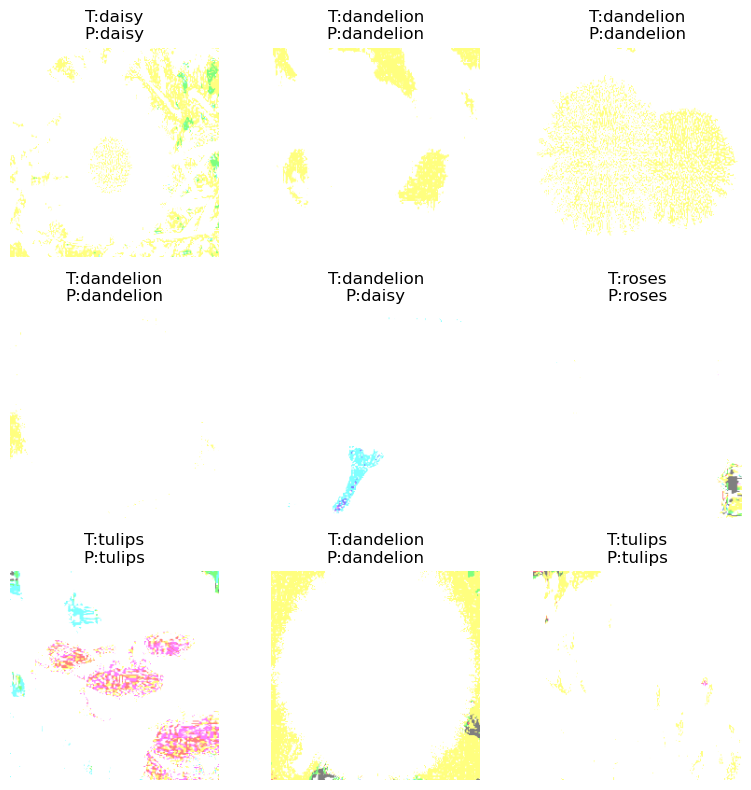

In [12]:
# Cell 9: Evaluate & quick visualization of predictions

val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation Accuracy: {val_acc:.4f}")

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_idxs = tf.argmax(preds, axis=1).numpy()

    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() + 1) / 2)  # un-normalize [-1,1]→[0,1]
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_idxs[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break